# Exploratory Data Analysis and Modelling on Titanic Data Set
Lets import important libraries, define functions and import data aswell

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Model Selection Lib
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
pd.set_option('max_columns', None)

# I use PyCharm Dark so setting suitable style
sns.set(style='white', context='notebook', palette='deep')

train = pd.read_csv("Data/Titanic Data Set/train.csv")
test = pd.read_csv("Data/Titanic Data Set/test.csv")

# Save Test set ID for the last step
test_id = test['PassengerId']

## 1. Data Description
The following are the features present in the dataset and their description,

- PassengerId. Unique identification of the passenger. It shouldn't be necessary for the machine learning model.
- Survived. Survival (0 = No, 1 = Yes). Binary variable that will be our target variable.
- Pclass. Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
- Name. Name of the passenger. We need to parse before using it.
- Sex. Sex. Categorical variable that should be encoded.
- Age. Age in years.
- SibSp. # of siblings / spouses aboard the Titanic. 
- Parch. # of parents / children aboard the Titanic.
- Ticket. Ticket number. Need to understand its structure first.
- Fare. Passenger fare.
- Cabin. Cabin number. It needs to be parsed.
- Embarked. Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). Categorical feature that should be encoded.

The features we need and we can formulate new features from existing features using feature engineering to predict will the passenger survive or not from the sinkage/disaster.

In [5]:
# Numerical Features
num_features = ["Survived", "SibSp", "Parch", "Age", "Fare"]

## 2. Descriptive Statistics
We will generate the descriptive statistics to get the basic quantitative information about the features of our data set.

In [6]:
# Descriptive statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check for min and max values for the columns and see if they are reasonable. Also, notice the mean and standard deviation as mean gives the central tendancy of the data and `SD` gives the varaition in the data. A low standard deviation suggests that data points tend to be close to the mean vice versa.

Count gives the first glance at missing values in data and here we see **Age** seems to have some missing data.

Lets join the train and test set so the features match when it's time for testing, As we add some new features depending on the case during the feature engineering part of the analysis.

## 3. Outlier Detection
Before we move forward with missing values lets remove the outliers as they dramatically effect the distribution in data amd the models predictive capabilities.

The method we employ for outlier detection and removal is **Turkey Method** where we create bounds using IQR, Q1 and Q3 and points beyond these bounds are outliers.

In [7]:
# Create a Function to detect Outliers
def outliers(df, n, cols):
    """Takes a DataFrame and its features and returns a list of indices corresponding to the observations containing 
    more than n outliers"""
    indices = []
    
    # Iterate through columns
    for col in cols:
        # 1st Quartile Q1(25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd Quartile Q3(75%)
        Q3 = np.percentile(df[col], 75)
        # Inter Quarter Range(IQR)
        IQR = Q3 - Q1
        
        # Bounds
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        # Get indices of the outliers
        indices_list = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        
        # Append indices of the col to the total indices
        indices.extend(indices_list)
    
    # Select observations containing more than 'n' outliers
    indices = Counter(indices)
    multiple_outliers = list(k for k, v in indices.items() if v > n)
    
    return multiple_outliers


# Detect Outliers from Numerical Features
outliers_to_drop = outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
outliers_to_drop

C:\Users\Shashank\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

Let's have a look at our outliers, and see why they are so...

In [8]:
train.iloc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10 outliers, 3(28, 89, 342) have very high ticket fare and remaining 7 have very high Sibsp. That many siblings is unusual. Lets drop these values.

In [9]:
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [10]:
# Joining train and test set
df = pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## 4. Dealing with Missing values
Usual 3 ways to deal with missing data are.,
- Use only valid data, deleting the cases where data is missing.
- Impute data using values from similar cases or using the mean value.
- Impute data using model-based methods, in which models are defined to predict the missing values.

In [11]:
# Missing data statistics
df.fillna(np.nan, inplace=True)
miss_count = train.isnull().sum().sort_values(ascending=False)
miss_percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([miss_count, miss_percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Cabin,680,77.185017
Age,170,19.296254
Embarked,2,0.227015
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


Cabin seems to have lot of missing values, we could delete this off but lets check it once before we do it. Age has a few and can be imputed with a value once we observe that column. As for Embarked only has 2 observations missing we can just drop these observations without effecting the data or fill them with any values that seems reasonable when observing the column.

We are not including the joined dataset as the Survival column in test set is empty and leads to showing suvival having missing data.

In [12]:
# Check dtypes
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
# Check Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [14]:
# Descriptive statistics after removing outliers
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 5. Exploratory Data Analysis (Numerical Values)

Lets perform EDA on the numerical values of the data to begin with,

### Correlation Heat Map of Numerical Features and Survival


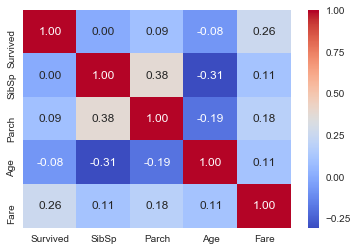

In [15]:
# Correlation heat map between numerical features and target variable
sns.heatmap(train[num_features].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Only Fare seems to have very high correlation with survival but as we know and studied that Titanic had 3 hrs to sink, so people kept their cool and boarded kids and women to the life boats first so they played a major role aswell. 

Lets explore the possibilities more with each feature.

### 5.1 SibSp - # of siblings / spouses aboard the Titanic.

Passengers having a lot of siblings/spouses have less chance to survive. Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive, we can consider a new feature describing these categories

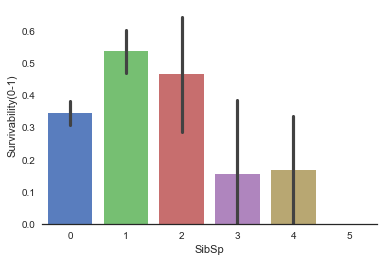

In [16]:
sns.barplot(x='SibSp', y='Survived', data=train, palette='muted')
plt.ylabel('Survivability(0-1)')
sns.despine(left=True)

### 5.2 Parch - # of parents / children aboard the Titanic.
Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6 ).

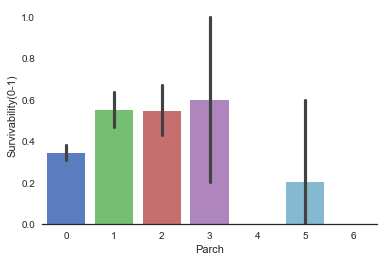

In [17]:
sns.barplot(x='Parch', y='Survived', data=train, palette='muted')
plt.ylabel('Survivability(0-1)')
sns.despine(left=True)

### 5.3 Age
Since we know age played a major role in survival, we better explore it thoroughly and get some insight to the feature engineering part.

C:\Program Files\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


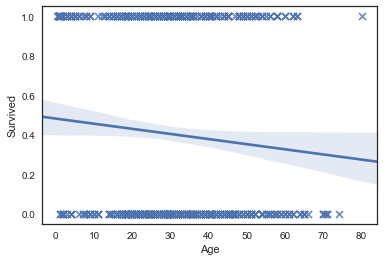

<Figure size 432x288 with 0 Axes>

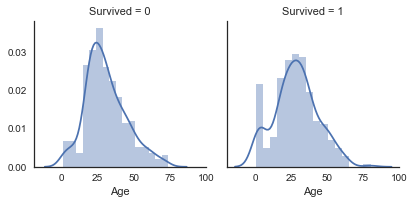

In [18]:
sns.regplot(x='Age', y='Survived', data=train, marker='x')
plt.figure()
sns.FacetGrid(train, col='Survived').map(sns.distplot, 'Age')

We can see age is negatively correlated to survival and younger people have more chance for survival. Lets explore the abnormaility of the ditribution when survived as we see a left skewed distribution

Text(0,0.5,'Frequency')

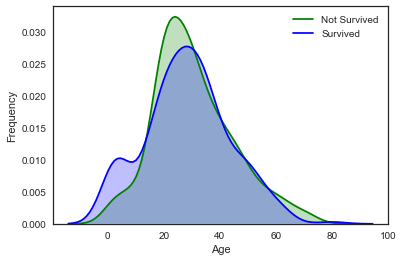

In [19]:
ax = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Green', shade=True)
sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color='Blue', shade=True, ax=ax)
plt.legend(['Not Survived', 'Survived'])
plt.xlabel('Age')
plt.ylabel('Frequency')

Super-imposing the densities, we can see the bump we observed in distribution plot showing that babies and younger children had high survival.

### 5.4 Fare - Ticket Fare
We know fare had a single missing value lets fill that observation with median value. Than explore its distribution, Skewness and so on.

In [20]:
df['Fare'] = df['Fare'].fillna(df.Fare.median())
df.Fare.isnull().sum()

0

C:\Program Files\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


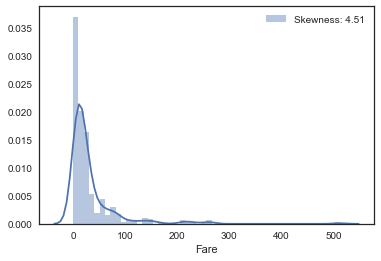

In [21]:
# Fare Distribution
sns.distplot(df.Fare, label=f"Skewness: {df.Fare.skew():.2f}")
plt.legend(loc='best')

Fare is very much +vely skewed and this will lead to overweigh high values in the models. Let's do a log transformation to normalize the distribution.

C:\Program Files\Python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


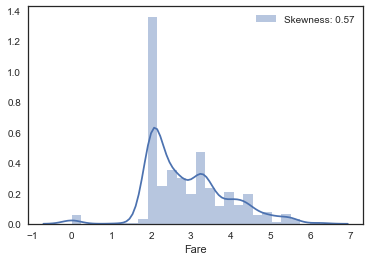

In [22]:
df['Fare'] = df['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
sns.distplot(df.Fare, label=f"Skewness: {df.Fare.skew():.2f}")
plt.legend(loc='best')

## 6. Exploratory Data Analysis (Categorical)
Now, lets move to categorical values of the dataset.

### 6.1 Sex - Gender of the passenger
We can say females have higher chance of survival than males as we have read/seen women and children were boarded the life boats first.

,Survived
Sex,
female,0.747573
male,0.190559


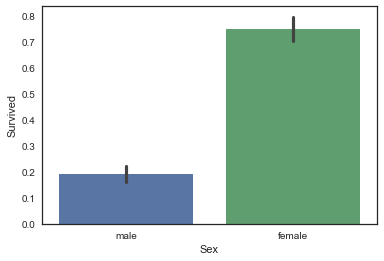

In [23]:
sns.barplot(x='Sex', y='Survived', data=train)

# Lets also the check the mean of the survival based on Sex
train[['Sex', 'Survived']].groupby('Sex').mean()

### 6.2 Pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

First Class has very high survival rate thand 2nd and 3rd class as expected. We have to check if Sex increased the chances of the lower classes passengers too.

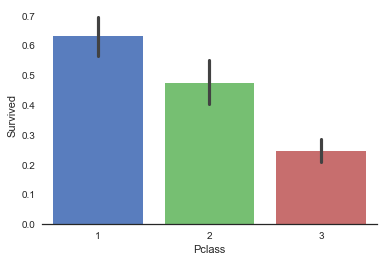

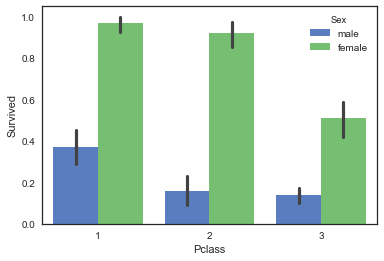

In [24]:
sns.barplot(x='Pclass', y='Survived', data=train, palette='muted')
sns.despine(left=True)
plt.figure()
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, palette='muted')

### 6.3 Embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
We know that embarked had 2 missing values from the previous analysis lets fill it with the mode of the data i.e `S`.

In [25]:
df['Embarked'] = df['Embarked'].fillna('S')
df.Embarked.isnull().sum()

0

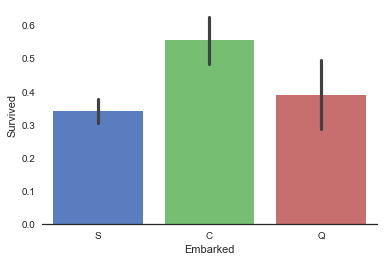

In [26]:
sns.barplot(x='Embarked', y='Survived', data=train, palette='muted')
sns.despine(left=True)

Passengers from `C` have high survival we can hypothesize that `C` had more first class passengers and them being females probably so let's verify this hypotheis with viable data.

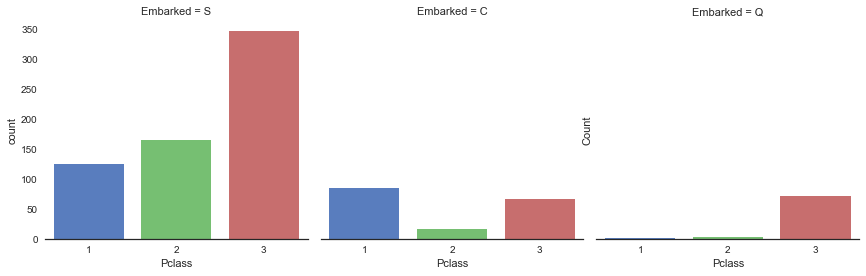

<Figure size 432x288 with 0 Axes>

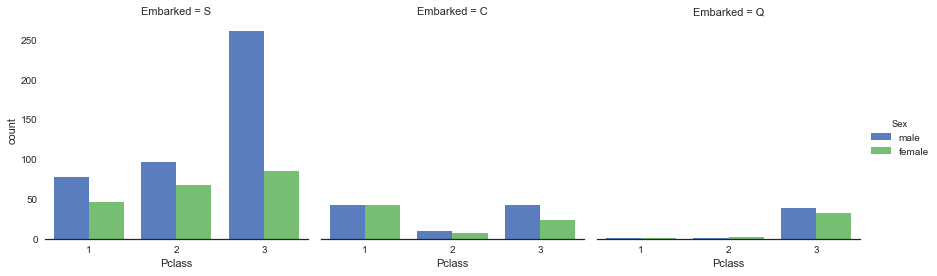

In [27]:
sns.factorplot('Pclass', col='Embarked', data=train, palette='muted', kind='count')
sns.despine(left=True)
plt.ylabel('Count')
plt.figure()
sns.factorplot('Pclass', col='Embarked', hue='Sex', data=train, palette='muted', kind='count')
sns.despine(left=True)

Third class was most frequent for passenger coming from `S` and `Q` whereas `C` had mostly first class passengers and also `C` had bit lower number female count than male but very close unlike the other boarding areas where males dominated the numbers.

## 7. Feature Engineering and Missing Values
### 7.1 Age
As we have already counted the number of missing values before we know we haven't dealt with `Age` yet and it has 256 missing values and our observations indicate that age plays a major role in prediction so lets impute the values based on their `Title` in the `Name` column.

We can do this by using the information in the variable 'Name'. Looking to 'Name' values, we can see person's name and title. Person's title is a relevant information to estimate ages. To give an example, we know that a person with the title 'Master' is someone under 13 years old, since 'a boy can be addressed as master only until age 12'. Therefore, employing the information in 'Name' we can improve our imputation method.

Lets also check the correlation between Age, Sex, SibSp, Parch and Pclass if they can be indicative of the age in any manner.

In [28]:
# Sex is Categorical so change to dummy variables to do a correlation map
df.Sex = df.Sex.map({'male': 0, 'female': 1})

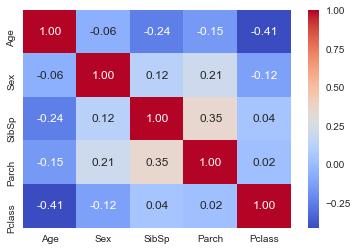

In [29]:
sns.heatmap(df[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='coolwarm', annot=True, fmt='.2f')

In [30]:
# Check Name patterns
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [31]:
# Extract the titles from name
df['Title'] = 0
for i in df:
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr


In [32]:
# Unique Titles
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

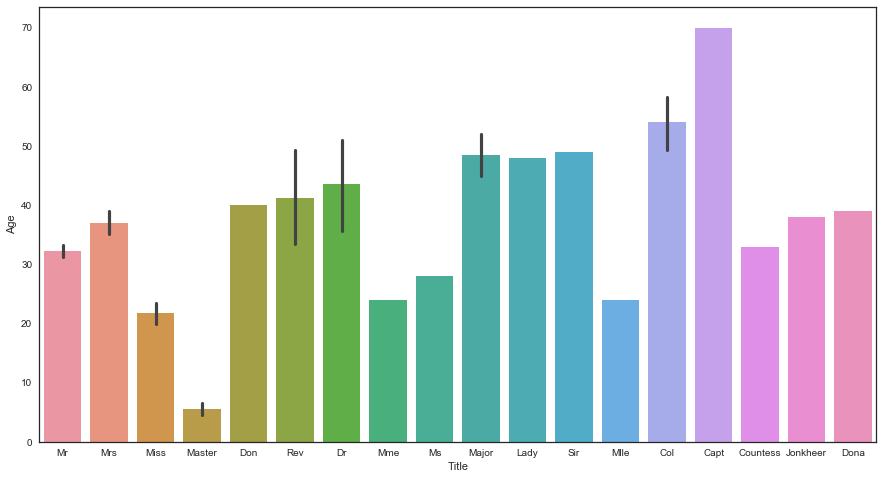

In [33]:
# Plot ages for different titles to verify our hypothesis
plt.figure(figsize=(15, 8))
sns.barplot(x='Title', y='Age', data=df)

In [34]:
# Replace rare titles with common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute: object = df.groupby('Title')['Age'].median()[titles.index(title)] 
    df.loc[(df['Age'].isnull()) & (df['Title'] == title), 'Age'] = age_to_impute

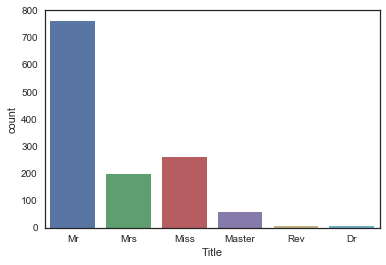

In [35]:
sns.countplot(df.Title)

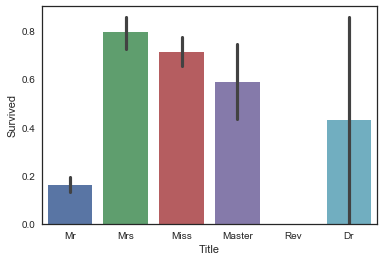

In [36]:
# Plot against Survived
sns.barplot(x='Title', y='Survived', data=df)

### 7.2 Family Size (SbSip + Parch)
We can hypothesize larger families having more difficulty to evacuate, reason being looking for sisters/brothers/parents. So, lets create a feature called `Family Size` to see how it does against survival.

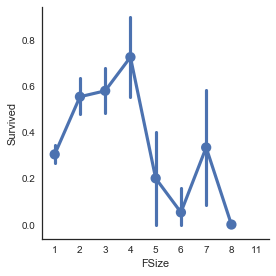

In [37]:
# Combine the siblings and parents
df['FSize'] = df['SibSp'] + df['Parch'] + 1

# Plot against survival
sns.factorplot(x='FSize', y='Survived', data=df)

The family size seems to play a good bit of a role in survival and showing the bigger families had the lowest survival. So, Lets make bins of family size as categorical and check their survival per bin.

In [38]:
df['Single'] = df.FSize.map(lambda x: 1 if x == 1 else 0)
df['Small_F'] = df.FSize.map(lambda x: 1 if x == 2 else 0)
df['Med_F'] = df.FSize.map(lambda x: 1 if 4 >= x >= 3 else 0)
df['Lar_F'] = df.FSize.map(lambda x: 1 if x >= 5 else 0)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,FSize,Single,Small_F,Med_F,Lar_F
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,Mr,2,0,1,0,0
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,Mrs,2,0,1,0,0
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,Miss,1,1,0,0,0
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,Mrs,2,0,1,0,0
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,Mr,1,1,0,0,0


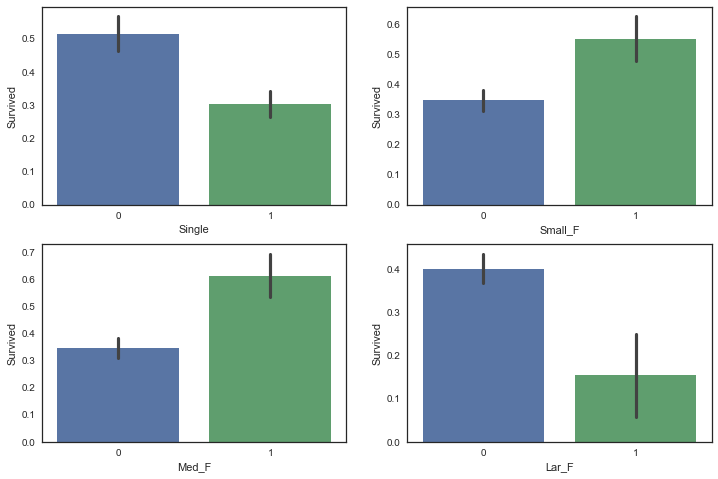

In [39]:
f, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.barplot(x='Single', y='Survived', data=df, ax=ax[0, 0])
sns.barplot(x='Small_F', y='Survived', data=df, ax=ax[0, 1])
sns.barplot(x='Med_F', y='Survived', data=df, ax=ax[1, 0])
sns.barplot(x='Lar_F', y='Survived', data=df, ax=ax[1, 1])

In [40]:
# Convert categorical values into numerical using dummy values
df = pd.get_dummies(df, columns=['Title'])
df = pd.get_dummies(df, columns=['Embarked'], prefix='Em')

In [41]:
df.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FSize,Single,Small_F,Med_F,Lar_F,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171,2,0,1,0,0,0,0,0,1,0,0,0,0,1
1,38.0,C85,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,2,0,1,0,0,0,0,0,0,1,0,1,0,0
2,26.0,NaN,2.070022,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,1,1,0,0,0,0,0,1,0,0,0,0,0,1
3,35.0,C123,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,2,0,1,0,0,0,0,0,0,1,0,0,0,1
4,35.0,NaN,2.085672,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450,1,1,0,0,0,0,0,0,1,0,0,0,0,1


### 7.4 Cabin
This ccolumn has many missing values, about 1007 missing values as we have seen before. According to study cabins were not given to everyone so people wiht missing cabin number just didn't get alloted a cabin as being single or for some other reason.

So, lets replace the cabin number null values with a varaible like `X` to denote the passengers without cabin. 

Also, we can see that the cabin numbers are starting with a Varaible denoting the `Desk` there were assinged to so lets replace cabin values with Desk numbers and check of any Desk had any higher chance of survival.

In [42]:
# Replace the Cabin number by the type of cabin and  'X' if not
df['Cabin'] = pd.Series(list(i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']))
df.Cabin.unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

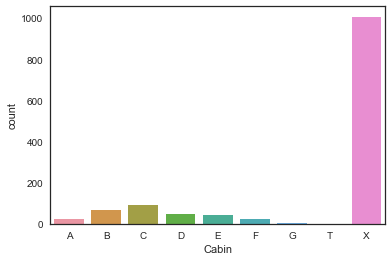

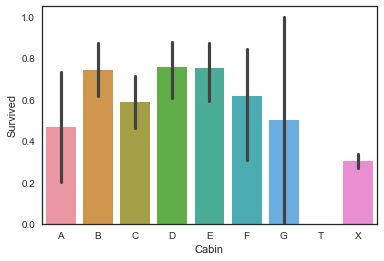

In [43]:
# Checking the survivability of each cabin
sns.countplot(df.Cabin, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
plt.figure()
sns.barplot(x='Cabin', y='Survived', data=df, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

Hmm, we can just conclude that passengers with Cabins were having higher chance than ones without. So, lets get dummies for the cabin variables aswell.

In [44]:
df = pd.get_dummies(df, columns=['Cabin'], prefix='Cab')
df.columns

Index(['Age', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'FSize', 'Single', 'Small_F', 'Med_F', 'Lar_F',
       'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rev', 'Em_C', 'Em_Q', 'Em_S', 'Cab_A', 'Cab_B', 'Cab_C', 'Cab_D',
       'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X'],
      dtype='object')

### 7.5 Ticket
This can be dealt with the same manner as Cabin by replacing prefixes and making dummy variables out of it.

In [45]:
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
        
df["Ticket"] = Ticket
df["Ticket"].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [46]:
# Get dummies for Ticket
df = pd.get_dummies(df, columns=['Ticket'], prefix='T')
df.columns

Index(['Age', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'FSize', 'Single', 'Small_F', 'Med_F', 'Lar_F', 'Title_Dr',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
       'Em_C', 'Em_Q', 'Em_S', 'Cab_A', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E',
       'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3',
       'T_AQ4', 'T_AS', 'T_C', 'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa',
       'T_LINE', 'T_LP', 'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4',
       'T_SCAH', 'T_SCOW', 'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP',
       'T_SOPP', 'T_SOTONO2', 'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2',
       'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP', 'T_X'],
      dtype='object')

In [47]:
# Create Dummies for Pclass as well
df.Pclass.dtype  # int64

# Convert to categorical
df['Pclass'] = df['Pclass'].astype('category')
df.Pclass.dtype

CategoricalDtype(categories=[1, 2, 3], ordered=False)

In [48]:
# Drop PassengerId, Name
df.drop(labels=['PassengerId', 'Name'], axis=1, inplace=True)
df.columns

Index(['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'FSize',
       'Single', 'Small_F', 'Med_F', 'Lar_F', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Em_C', 'Em_Q',
       'Em_S', 'Cab_A', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G',
       'Cab_T', 'Cab_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS',
       'T_C', 'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP',
       'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X'],
      dtype='object')

This concludes the EDA and Feature Engineering part of the dataset and let's move on to the Modelling part!

## 8. Predictive Modelling


In [49]:
# Separate dataset as we combined before to 'Train' and 'Test' dataset
train_1 = df[: len(train)]
test_1 = df[len(train):]
test_1 = test_1.drop(labels=['Survived'], axis=1)

In [50]:
Y_train = train_1.Survived
X_train = train_1.drop(labels=['Survived'], axis=1)

Let's start with a simple model and see how well our data does.

In [51]:
# KNN with Grid Search CV
n_neighbors = [6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list((range(1, 50, 5)))
hyper_params = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
                'n_neighbors': n_neighbors}

# n_jobs usually equal or below the number of cores in you CPU
gs_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyper_params, verbose=True, cv=10, scoring="roc_auc", 
                     n_jobs=3)
gs_cv.fit(X_train, Y_train)
print('The Best Score is: {:.3f}'.format(gs_cv.best_score_))
print('The Best Estimator is: ', gs_cv.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=3)]: Done  58 tasks      | elapsed:    3.1s


[Parallel(n_jobs=3)]: Done 442 tasks      | elapsed:   11.5s


[Parallel(n_jobs=3)]: Done 1442 tasks      | elapsed:   21.8s


The Best Score is: 0.826
The Best Estimator is:  KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')


[Parallel(n_jobs=3)]: Done 2400 out of 2400 | elapsed:   30.6s finished


Even a simple model gave a good estiamate of `0.826` So, if we can further improve the feature engineering we can accomplish better scores with just a single model.

One way to do that would making bins out of **Fare** and **Age** as we have not dealt with them much and see if binning them would be efficient to increase the score or not.

### 7.1.1 Age (revisited)
Make 3 age groups and bin them accordingly using `sklearn`'s `Label Encoder`.

In [52]:
from sklearn.preprocessing import LabelEncoder

df['AgeBin'] = pd.qcut(df['Age'], 4)

label = LabelEncoder()
df['AgeBin_Code'] = label.fit_transform(df['AgeBin'])
df.drop(labels=['Age', 'AgeBin'], axis=1, inplace=True)

In [53]:
df.columns

Index(['Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'FSize',
       'Single', 'Small_F', 'Med_F', 'Lar_F', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Em_C', 'Em_Q',
       'Em_S', 'Cab_A', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G',
       'Cab_T', 'Cab_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS',
       'T_C', 'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP',
       'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X', 'AgeBin_Code'],
      dtype='object')

### 7.6 Fare
Do the same for the Fare feature by groupoing into 4 or 5 bins and encode them.

In [54]:
df['FareBin'] = pd.qcut(df['Fare'], 5)
df['FareBin_Code'] = label.fit_transform(df['FareBin'])
df.drop(labels=['Fare', 'FareBin'], axis=1, inplace=True)

In [55]:
df.columns

Index(['Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'FSize', 'Single',
       'Small_F', 'Med_F', 'Lar_F', 'Title_Dr', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Em_C', 'Em_Q', 'Em_S', 'Cab_A',
       'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X',
       'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C', 'T_CA',
       'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC', 'T_PP',
       'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW', 'T_SCPARIS',
       'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2', 'T_SOTONOQ',
       'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP',
       'T_X', 'AgeBin_Code', 'FareBin_Code'],
      dtype='object')

## 8. Predictive Modelling (Continued)
After making bins of the fares and ages let see if the model does better.

In [56]:
# Separate dataset as we combined before to 'Train' and 'Test' dataset
train_2 = df[: len(train)]
test_2 = df[len(train):]
test_2 = test_2.drop(labels=['Survived'], axis=1)

Y_train = train_2.Survived
X_train = train_2.drop(labels=['Survived'], axis=1)


In [57]:
# KNN with Grid Search CV
n_neighbors = [6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list((range(1, 50, 5)))
hyper_params = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
                'n_neighbors': n_neighbors}

# n_jobs usually equal or below the number of cores in you CPU
gs_knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyper_params, verbose=True, cv=10, 
                         scoring="roc_auc", n_jobs=3)
gs_knn_cv.fit(X_train, Y_train)
knn_best = gs_knn_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_knn_cv.best_score_))
print('The Best Estimator is: ', gs_knn_cv.best_estimator_)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.3s


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   10.9s


[Parallel(n_jobs=3)]: Done 1005 tasks      | elapsed:   28.7s


The Best Score is: 0.861
The Best Estimator is:  KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')


[Parallel(n_jobs=3)]: Done 2400 out of 2400 | elapsed:   48.3s finished


Making bins and grouping them really did increase the score to `0.861` from `0.826`. With just a single model we got a good score.
So, Feature engineering really helps to get good score and improve a models accuracy more.

Lets try doing it with other models and see if score improves. We can even do some ensembling to see if score improves more.

### 8.1 Multiple Models
Lets model the data using different models and see which model does better. Cross Validate the models based mean accuracy using `Statified KFold Cross Validation`

In [58]:
# Cross Val with Stratified KFold
k_fold = StratifiedKFold(n_splits=10)

# Models
random_state = 3
classifiers = [SVC(random_state=random_state), 
               DecisionTreeClassifier(random_state=random_state),
               AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, 
                                  learning_rate=0.01),
               GradientBoostingClassifier(random_state=random_state),
               RandomForestClassifier(random_state=random_state),
               MLPClassifier(random_state=random_state),
               ExtraTreesClassifier(random_state=random_state),
               LogisticRegression(random_state=random_state)]

cv_results = [cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=k_fold, n_jobs=4)
              for classifier in classifiers]
cv_means, cv_std = [], []
for result in cv_results:
    cv_means.append(result.mean())
    cv_std.append(result.std())

cv_res_df = pd.DataFrame({'Cross_Val_Means': cv_means, 'Cross_Val_Errors': cv_std,
                          'Algorithms': ['SVC', 'Decision Tree Classifier', 'AdaBoost', 'GradientBoost', 
                                         'Random Forest', 'MLP Classifier', 'Extra Tree Classifier', 
                                         'Logistic Regression']})
cv_res_df.sort_values('Cross_Val_Means', ascending=False)

,Cross_Val_Means,Cross_Val_Errors,Algorithms
0,0.829724,0.039091,SVC
5,0.825217,0.032900,MLP Classifier
7,0.824068,0.035637,Logistic Regression
3,0.817250,0.038193,GradientBoost
4,0.803690,0.035905,Random Forest
2,0.799119,0.042989,AdaBoost
1,0.796897,0.045408,Decision Tree Classifier
6,0.796885,0.045216,Extra Tree Classifier


Text(0.5,1,'Cross Validation Scores')

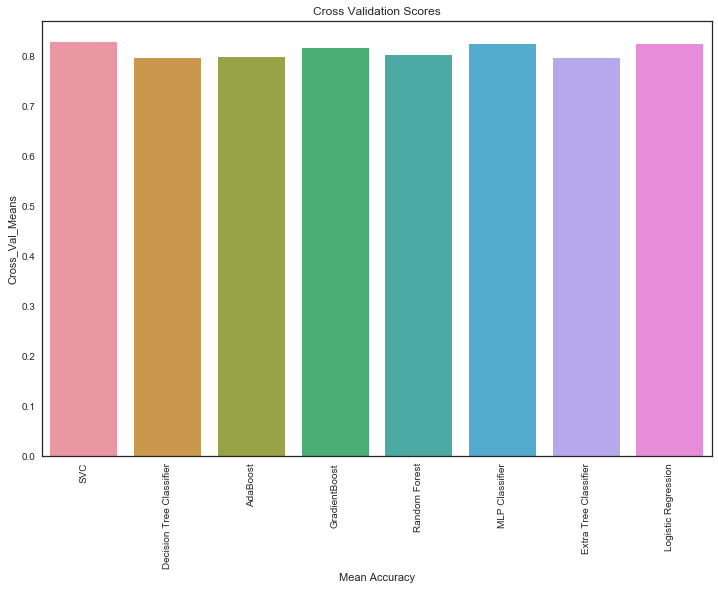

In [59]:
# Plot to check which algorithms did better
plt.figure(figsize=(12, 8))
sns.barplot(x='Algorithms', y='Cross_Val_Means', data=cv_res_df)
plt.xticks(rotation=90)
plt.xlabel('Mean Accuracy')
plt.title('Cross Validation Scores')

### 8.2 Choose best and Hyper parameter tuning
Lets choose our top performers and do hyper parameter tuning with grid search cv like before.

Choosing SVC, AdaBoost, Random Foest, GradientBoosting and ExtraTrees, Since boosting algorithms really shine when hyper tuned else they overfit easily.

In [60]:
# SVC Classifier
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]}
gs_svm_cv = GridSearchCV(SVC(probability=True), param_grid=svc_param_grid, cv=k_fold, scoring='accuracy', n_jobs=4,
                         verbose=1)
gs_svm_cv.fit(X_train, Y_train)
svc_best = gs_svm_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_svm_cv.best_score_))
print('The Best Estimator is: ', gs_svm_cv.best_estimator_)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   22.8s finished


The Best Score is: 0.831
The Best Estimator is:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [61]:
# AdaBoost
ada_dt = AdaBoostClassifier(DecisionTreeClassifier(), random_state=7)
ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"], 
                  "base_estimator__splitter": ["best", "random"],
                  "algorithm": ["SAMME", "SAMME.R"],
                  "n_estimators": [1, 2],
                  "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gs_ada_cv = GridSearchCV(ada_dt, param_grid=ada_param_grid, cv=k_fold, scoring='accuracy', n_jobs=4, verbose=1)
gs_ada_cv.fit(X_train, Y_train)
ada_best = gs_ada_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_ada_cv.best_score_))
print('The Best Estimator is: ', gs_ada_cv.best_estimator_)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 176 tasks      | elapsed:    2.8s


The Best Score is: 0.806
The Best Estimator is:  AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.0001, n_estimators=1, random_state=7)


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.2s finished


In [62]:
# Extra Trees Classifier
ex_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"]}
gs_ext_cv = GridSearchCV(ExtraTreesClassifier(), param_grid=ex_param_grid, cv=k_fold, scoring='accuracy', n_jobs=4, 
                         verbose=1)
gs_ext_cv.fit(X_train, Y_train)
ext_best = gs_ext_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_ext_cv.best_score_))
print('The Best Estimator is: ', gs_ext_cv.best_estimator_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.3s


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   42.8s finished


The Best Score is: 0.834
The Best Estimator is:  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [63]:
# Random Forest
rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ["gini"]}
gs_rf_cv = GridSearchCV(RandomForestClassifier(), param_grid=rf_param_grid, cv=k_fold, scoring='accuracy', n_jobs=4,
                        verbose=1)
gs_rf_cv.fit(X_train, Y_train)
rf_best = gs_rf_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_rf_cv.best_score_))
print('The Best Estimator is: ', gs_rf_cv.best_estimator_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.6s


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.0s


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   47.8s finished


The Best Score is: 0.833
The Best Estimator is:  RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [64]:
# Gradient Boosting Classifier
gb_param_grid = {'loss': ["deviance"],
                 'n_estimators': [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1]}
gs_gb_cv = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_param_grid, cv=k_fold, scoring='accuracy', n_jobs=4,
                        verbose=1)
gs_gb_cv.fit(X_train, Y_train)
gb_best = gs_gb_cv.best_estimator_
print('The Best Score is: {:.3f}'.format(gs_gb_cv.best_score_))
print('The Best Estimator is: ', gs_gb_cv.best_estimator_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s


[Parallel(n_jobs=4)]: Done 337 tasks      | elapsed:   12.8s


[Parallel(n_jobs=4)]: Done 713 out of 720 | elapsed:   23.8s remaining:    0.1s


[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   24.1s finished


The Best Score is: 0.833
The Best Estimator is:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


### 8.3 Feature Importance of Classifiers
Trying to check which features are important for each classifier we trained and see if they are using the same features or different...

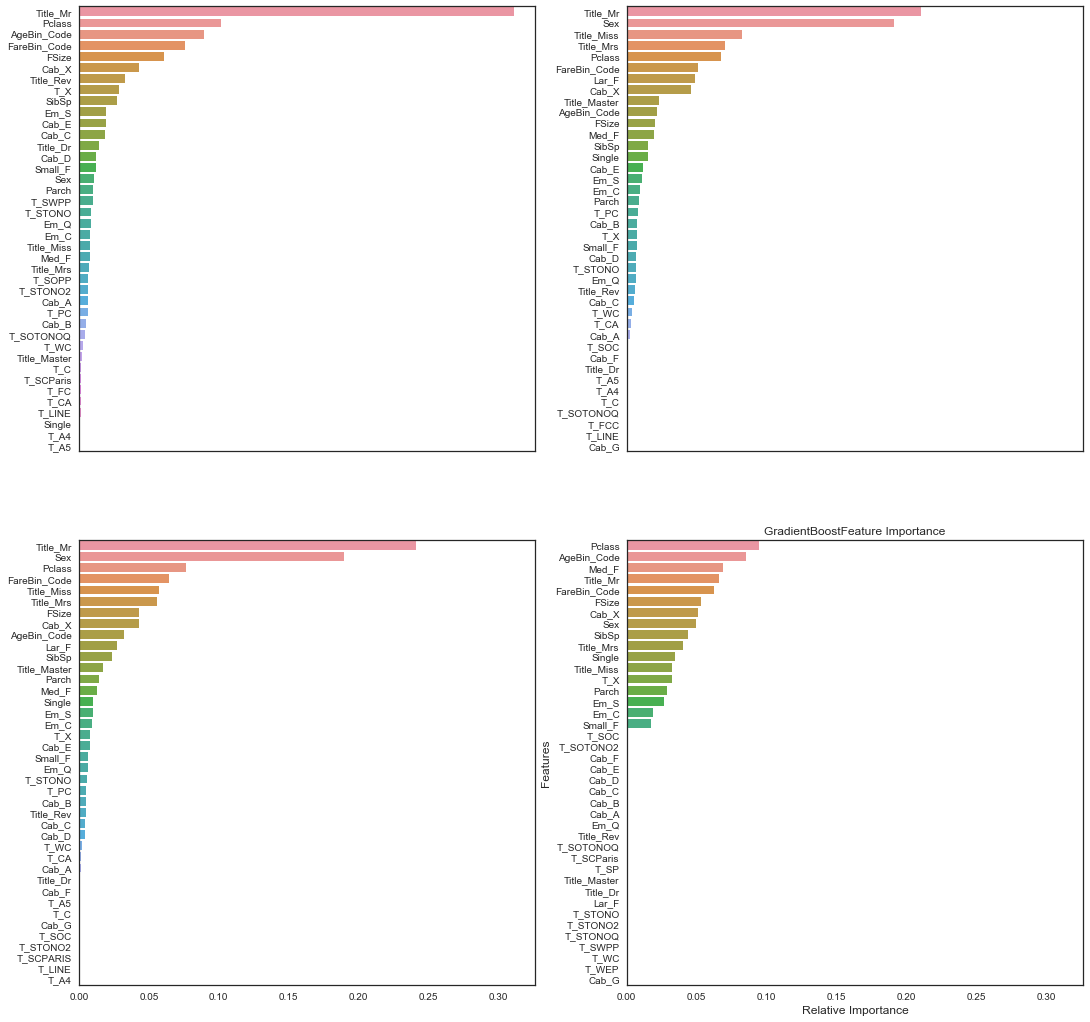

In [65]:
n_rows = n_columns = 2
f, ax = plt.subplots(nrows=n_rows, ncols=n_columns, sharex='all', figsize=(18, 18))
classifier_list = [('AdaBoost', ada_best), 
                   ('ExtraTrees', ext_best), 
                   ('RandomForest', rf_best), 
                   ('GradientBoost', gb_best)]
n_classifier = 0
for row in range(n_rows):
    for col in range(n_columns):
        name = classifier_list[n_classifier][0]
        classifier = classifier_list[n_classifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        sns.barplot(x=classifier.feature_importances_[indices][:40], y=X_train.columns[indices][:40], orient='h', 
                    ax=ax[row][col])
        plt.xlabel('Relative Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title(name + 'Feature Importance')
        n_classifier += 1

Looking at the feature importance of the tree based classifiers (Adaboost, ExtraTree, RandomForest and GradientBoosting). We can see that `Title`, `AgeBin_Code`, `Sex`, `FareBin_Code`, `Pclass`, `FSize` are common important features in all the classifiers.

So, binning into groups in conclusive to increase the accuracy greatly!

### 8.3 Testing Models
Lets test the models on the test set we have and see how the results are compared to each classifier and how much they differ! Since the accuracy was close enough around `0.83-0.87` we should see close enough predcitions but if they differ we can go for ** Ensemble Modelling** to get better prediction.

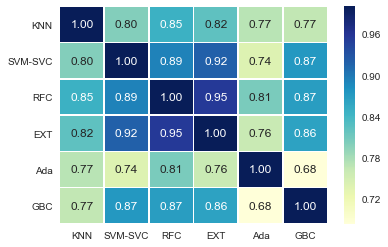

In [66]:
# Testing Models
best_classifier_names = ['KNN', 'SVC', 'RFC', 'EXT', 'Ada', 'GBC']
best_classifier_list = [knn_best, svc_best, rf_best, ext_best, ada_best, gb_best]

test_knn = pd.Series(knn_best.predict(test_2), name='KNN')
test_rfc = pd.Series(rf_best.predict(test_2), name='RFC')
test_ext = pd.Series(ext_best.predict(test_2), name='EXT')
test_svc = pd.Series(svc_best.predict(test_2), name='SVM-SVC')
test_ada = pd.Series(ada_best.predict(test_2), name='Ada')
test_gbc = pd.Series(gb_best.predict(test_2), name='GBC')

# Concatenate the Results
result_ensemble = pd.concat([test_knn, test_svc, test_rfc, test_ext, test_ada, test_gbc], axis=1)

# Plot
sns.heatmap(result_ensemble.corr(), annot=True, fmt='.2f', cmap="YlGnBu", linewidths=0.5)


These seems to be mostly same but some predictions were not so good and there seem to be differences in thr results hence the less correlation, so ensemble of these models will yeild better results all together.

### 8.4 Ensemble Modelling
Lets choose a simple [Voting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) to combine our models as the data is simple enough and has been feature engineered by every column.

In [67]:
voting_estimators = list(zip(best_classifier_names, best_classifier_list))
voting_c = VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=4)
voting_c.fit(X_train, Y_train)


VotingClassifier(estimators=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')), ('SVC', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=4, voting='soft', weights=None)

In [68]:
voting_c.score(X_train, Y_train)

C:\Program Files\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8649262202043133

The mean accuracy score of through ensembling improved the score only by a bit (0.861 to 0.865) but larger the dataset the score differene will be better. We can even weigh the voting based on the individual performance we have seen by these models. This could lead to bit more of better score.

So, lets predict the test set using this model!!

## 9. Prediction!
Predict the test set with trained model and create a list of predictions~

In [69]:
test_Survived = pd.Series(voting_c.predict(test_2), name='Survived', dtype='int')
result = pd.concat([test_id, test_Survived], axis=1)
result.sample(5)

C:\Program Files\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,PassengerId,Survived
95,987,0
102,994,0
176,1068,1
135,1027,0
181,1073,0
